In [1]:
######LIBRARIES##################
import os # using WSL
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

########SEEDS####################
random.seed(42)
np.random.seed(42)

1. Plot the dataset noisy sin sample.csv

In [2]:
data = pd.read_csv("/home/colton_baker/msds/Spring 2025/Deep Learning/HW/HW2/noisy_sin_samples.csv", names=["X", "sin(X) + eps"])
df = pd.DataFrame(data)
df= df.sort_values(by="X")
df.describe()

,X,sin(X) + eps
count,21.000000,21.000000
mean,0.472563,0.111468
std,0.248512,0.728029
min,0.023528,-1.174500
25%,0.345450,-0.416320
50%,0.495330,0.042831
75%,0.597090,0.679350
max,0.953990,1.278800


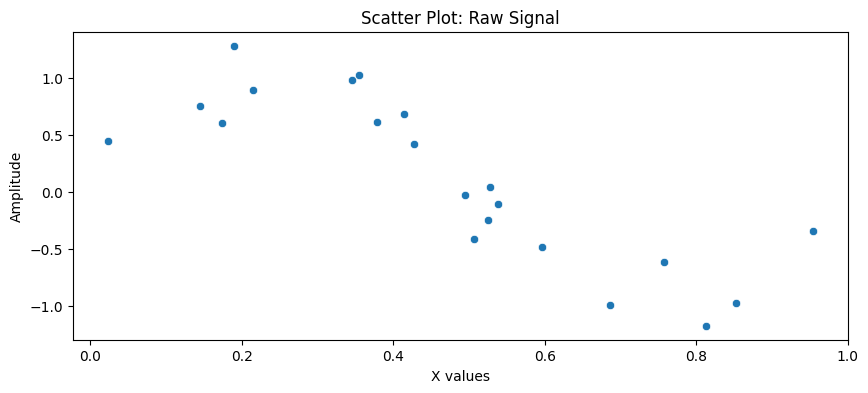

In [3]:
#scatter plot
plt.figure(figsize=(10,4))
sns.scatterplot(data=df, x="X", y="sin(X) + eps")
plt.xlabel("X values")
plt.ylabel("Amplitude")
plt.title("Scatter Plot: Raw Signal")
plt.show()

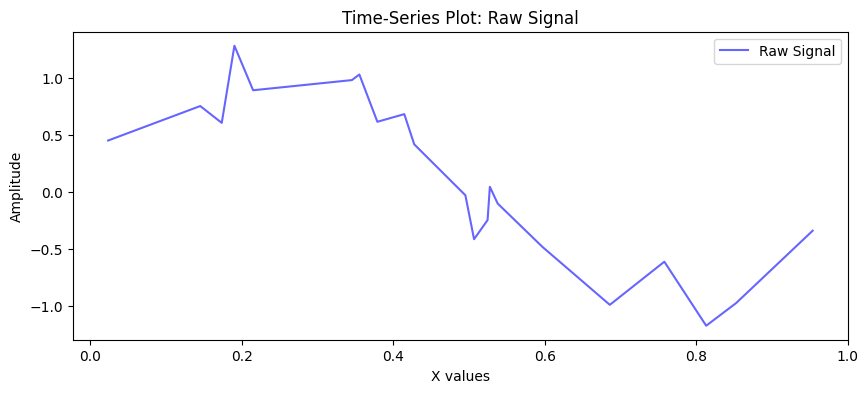

In [4]:
# time-series
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x="X", y="sin(X) + eps", label="Raw Signal", color="blue", alpha=0.6)
plt.xlabel("X values")
plt.ylabel("Amplitude")
plt.title("Time-Series Plot: Raw Signal")
plt.legend()
plt.show()

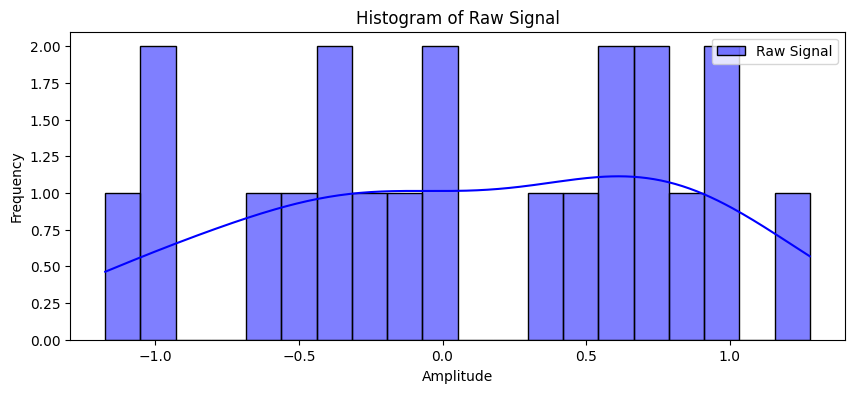

In [5]:

# histogram
plt.figure(figsize=(10,4))
sns.histplot(df["sin(X) + eps"], bins=20, kde=True, color="blue", label="Raw Signal", alpha=0.5)
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
plt.title("Histogram of Raw Signal")
plt.legend()
plt.show()

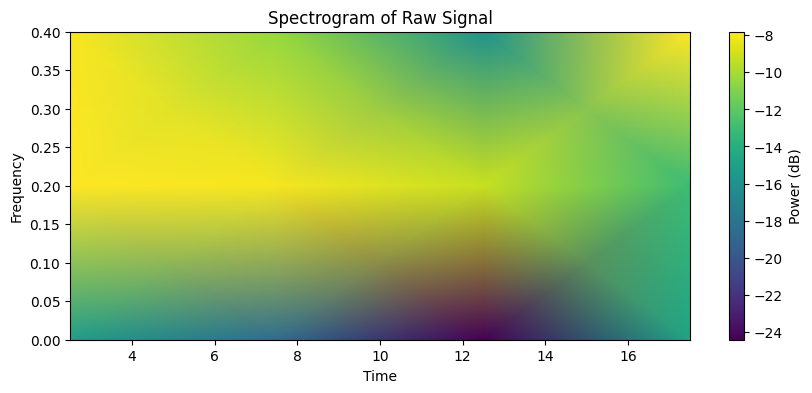

In [6]:

# spectrogram...did this for curiosity
frequencies, times, Sxx = spectrogram(df["sin(X) + eps"], fs=1, nperseg=5)  
plt.figure(figsize=(10,4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label="Power (dB)")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Spectrogram of Raw Signal")
plt.show()

2. Design three MLPs with 1 hidden layer and ReLU activation function for non-linear
regression using 50, 90 and 130 neurons in the hidden layer. For each architecture, train
a nonlinear regression model for varying numbers of epochs, and analyze the result
calculating the accuracy (MSE error).

In [7]:
# transform data to tensors first
X_tensor = torch.tensor(df["X"].values, dtype=torch.float32).reshape(-1, 1)
y_tensor = torch.tensor(df["sin(X) + eps"].values, dtype=torch.float32).reshape(-1, 1)

# then split into train-test sets

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42) #so long and thx for all the fish


In [8]:
# instantiate the non-linear model for varying hidden layer sizes
class NonLinearRegression(nn.Module):
    def __init__(self, hidden_size, activation_func=nn.ReLU()):
        super(NonLinearRegression, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size) # input -> hidden layer
        self.activation_func =  activation_func# activation function i.e. ReLU = max(0, x-c) or tanh(x)
        self.fc2 = nn.Linear(hidden_size,1) # hidden layer -> one cont. ouput (regression)
        
    def forward(self, x):
        x = self.activation_func(self.fc1(x)) # input -> activation
        x = self.fc2(x) # activated from hidden -> ouput
        return x # give me my output please

# define params
learning_rate = 0.01
hidden_sizes = [50, 90, 130]
num_epochs = 1000


In [15]:
torch.manual_seed(42)
# storing the loss for each model in dictionary
loss_histories_relu = {}
best_epochs_relu = {}

# training the non-linear models separately with nested loop
for size in hidden_sizes:
    relu_model = NonLinearRegression(hidden_size=size, activation_func=nn.ReLU()) #relu model
    relu_optimizer = optim.Adam(relu_model.parameters(), lr=learning_rate) #Adam optimizer
    relu_criterion = nn.MSELoss() # L(theta) = MSE (no reg without "weight decay")

    loss_history = [] # will go into dictionary or each model size

    for epoch in range(num_epochs):
        relu_optimizer.zero_grad() # clear gradient after each step so grads don't sum up
        relu_outputs = relu_model(X_train) # training data into model phi(x)
        relu_loss = relu_criterion(relu_outputs, y_train) # sum_1^{n}(y-yhat)^2
        relu_loss.backward() # compute grads for backprop
        relu_optimizer.step() # update weights

        loss_history.append(relu_loss.item()) # appending loss values for each epoch

        torch.save(relu_model.state_dict(), f"relu_model_{size}.pth")

        # printing the epochs for you
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Nonlinear Loss: {relu_loss.item():.4f}')
            
    # save model loss history and locating best epoch for relu part
    loss_histories_relu[size] = loss_history  
    best_epochs_relu[size] = torch.argmin(torch.tensor(loss_history)).item()



Epoch [10/1000], Nonlinear Loss: 0.4449
Epoch [20/1000], Nonlinear Loss: 0.2768
Epoch [30/1000], Nonlinear Loss: 0.1696
Epoch [40/1000], Nonlinear Loss: 0.1328
Epoch [50/1000], Nonlinear Loss: 0.1295
Epoch [60/1000], Nonlinear Loss: 0.1259
Epoch [70/1000], Nonlinear Loss: 0.1239
Epoch [80/1000], Nonlinear Loss: 0.1221
Epoch [90/1000], Nonlinear Loss: 0.1208
Epoch [100/1000], Nonlinear Loss: 0.1194
Epoch [110/1000], Nonlinear Loss: 0.1180
Epoch [120/1000], Nonlinear Loss: 0.1166
Epoch [130/1000], Nonlinear Loss: 0.1151
Epoch [140/1000], Nonlinear Loss: 0.1137
Epoch [150/1000], Nonlinear Loss: 0.1123
Epoch [160/1000], Nonlinear Loss: 0.1109
Epoch [170/1000], Nonlinear Loss: 0.1096
Epoch [180/1000], Nonlinear Loss: 0.1083
Epoch [190/1000], Nonlinear Loss: 0.1071
Epoch [200/1000], Nonlinear Loss: 0.1059
Epoch [210/1000], Nonlinear Loss: 0.1048
Epoch [220/1000], Nonlinear Loss: 0.1038
Epoch [230/1000], Nonlinear Loss: 0.1028
Epoch [240/1000], Nonlinear Loss: 0.1019
Epoch [250/1000], Nonline

In [10]:
print(f"\nBest epoch for {size} neurons (ReLU): {best_epochs_relu[size]}")


Best epoch for 130 neurons (ReLU): 999


3. Repeat the analysis, keeping the best epoch number found above using this time the Tanh
activation function.

In [16]:
# now the same for tanh but with the best epoch from tanh

# storing the loss for each model in dictionary
loss_histories_tanh = {}
best_epochs_tanh = {}

# training the non-linear models separately with nested loop
for size in hidden_sizes:
    best_epoch = best_epochs_relu[size]

    tanh_model = NonLinearRegression(hidden_size=size, activation_func=nn.Tanh()) #tanh model
    tanh_optimizer = optim.Adam(tanh_model.parameters(), lr=learning_rate) #Adam optimizer
    tanh_criterion = nn.MSELoss() # L(theta) = MSE (no reg without "weight decay")

    loss_history = [] # will go into dictionary or each model size

    for epoch in range(best_epoch + 1):
        tanh_optimizer.zero_grad() # clear gradient after each step so grads don't sum up
        tanh_outputs = tanh_model(X_train) # training data into model output phi(x)
        tanh_loss = tanh_criterion(tanh_outputs, y_train) # sum_1^{n}(y-yhat)^2
        tanh_loss.backward() # compute grads for backprop
        tanh_optimizer.step() # update weights

        loss_history.append(tanh_loss.item()) # appending loss values for each epoch

        torch.save(tanh_model.state_dict(), f"tanh_model_{size}.pth")

        # printing the epochs for you
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Nonlinear Loss: {tanh_loss.item():.4f}')
            
    # save model loss history and locating best epoch for tanh part
    loss_histories_tanh[size] = loss_history  
    best_epochs_tanh[size] = torch.argmin(torch.tensor(loss_history)).item()


Epoch [10/1000], Nonlinear Loss: 0.2860
Epoch [20/1000], Nonlinear Loss: 0.1429
Epoch [30/1000], Nonlinear Loss: 0.1566
Epoch [40/1000], Nonlinear Loss: 0.1436
Epoch [50/1000], Nonlinear Loss: 0.1421
Epoch [60/1000], Nonlinear Loss: 0.1413
Epoch [70/1000], Nonlinear Loss: 0.1401
Epoch [80/1000], Nonlinear Loss: 0.1395
Epoch [90/1000], Nonlinear Loss: 0.1388
Epoch [100/1000], Nonlinear Loss: 0.1380
Epoch [110/1000], Nonlinear Loss: 0.1373
Epoch [120/1000], Nonlinear Loss: 0.1364
Epoch [130/1000], Nonlinear Loss: 0.1356
Epoch [140/1000], Nonlinear Loss: 0.1347
Epoch [150/1000], Nonlinear Loss: 0.1339
Epoch [160/1000], Nonlinear Loss: 0.1330
Epoch [170/1000], Nonlinear Loss: 0.1321
Epoch [180/1000], Nonlinear Loss: 0.1313
Epoch [190/1000], Nonlinear Loss: 0.1305
Epoch [200/1000], Nonlinear Loss: 0.1296
Epoch [210/1000], Nonlinear Loss: 0.1288
Epoch [220/1000], Nonlinear Loss: 0.1280
Epoch [230/1000], Nonlinear Loss: 0.1272
Epoch [240/1000], Nonlinear Loss: 0.1263
Epoch [250/1000], Nonline

In [17]:
print(f"\nBest epoch for {size} neurons (Tanh): {best_epochs_tanh[size]}")


Best epoch for 130 neurons (Tanh): 999


Plot the regression results (superimposed to the original dataset as in the regression
example shown in class) for the two activation functions and provide observations on the
performance of each activation function, i.e., compare accuracy.

/tmp/ipykernel_67249/781445129.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  relu_model.load_state_dict(torch.load(f"relu_model_{size}.pth"))  # Load trained weights


/tmp/ipykernel_67249/781445129.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tanh_model.load_state_dict(torch.load(f"tanh_model_{size}.pth"))  # Load trained weights


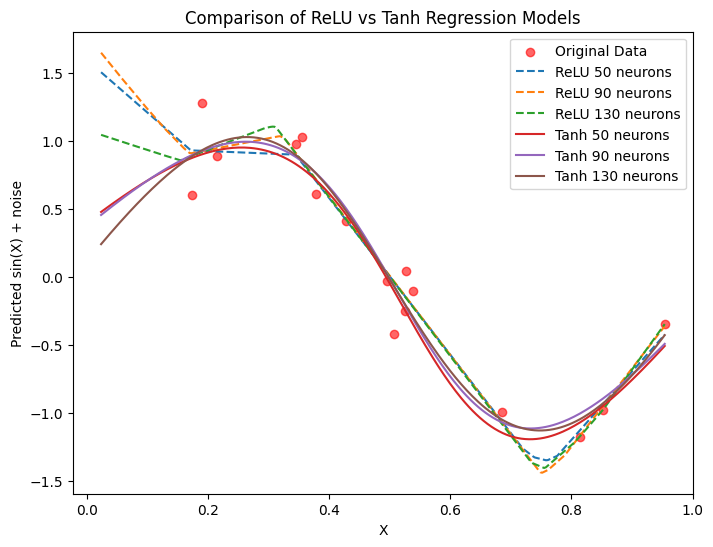

In [18]:
# Generate predictions for plotting
X_plot = torch.linspace(X_tensor.min(), X_tensor.max(), 300).unsqueeze(1)  # Generate 300 smooth X points

plt.figure(figsize=(8, 6))
plt.scatter(X_train.numpy(), y_train.numpy(), color='red', alpha=0.6, label='Original Data')

# Plot ReLU predictions
for size in hidden_sizes:
    relu_model = NonLinearRegression(hidden_size=size, activation_func=nn.ReLU())
    relu_model.load_state_dict(torch.load(f"relu_model_{size}.pth"))  # Load trained weights
    relu_model.eval()

    with torch.no_grad():
        y_relu_pred = relu_model(X_plot).numpy()  # Generate predictions

    # Sort values for smooth plotting
    sorted_indices = np.argsort(X_plot.numpy().flatten())
    plt.plot(X_plot.numpy()[sorted_indices], y_relu_pred[sorted_indices], linestyle="dashed", label=f"ReLU {size} neurons")

# Plot Tanh predictions
for size in hidden_sizes:
    tanh_model = NonLinearRegression(hidden_size=size, activation_func=nn.Tanh())
    tanh_model.load_state_dict(torch.load(f"tanh_model_{size}.pth"))  # Load trained weights
    tanh_model.eval()

    with torch.no_grad():
        y_tanh_pred = tanh_model(X_plot).numpy()  # Generate predictions

    # Sort values for smooth plotting
    sorted_indices = np.argsort(X_plot.numpy().flatten())
    plt.plot(X_plot.numpy()[sorted_indices], y_tanh_pred[sorted_indices], label=f"Tanh {size} neurons")

# Final plot settings
plt.xlabel("X")
plt.ylabel("Predicted sin(X) + noise")
plt.title("Comparison of ReLU vs Tanh Regression Models")
plt.legend()
plt.show()
